<a href="https://colab.research.google.com/github/SugnikMukherjee/ModelPredictiveController/blob/main/Casadi_implementation_MPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\begin{equation*}
\begin{aligned}
& \frac{d \beta}{d t}=\left[-\frac{2 C_f+2 C_r}{m v_x}\right] \beta+\left[-\frac{2 C_f l_f-2 C_r l_r}{m v_x^2}\right] r - r +\frac{2 C_f}{m v_x} \delta \\
& \frac{d r}{d t}=-\left[\frac{2 C_f l_f-2 C_r l_r}{I_z}\right] \beta+\left[-\frac{2 C_f l_f^2+2 C_r l_r^2}{I_z v_x}\right] r+\frac{2 C_f l_f}{I_z} \delta+\frac{M_z}{I_z} .
\end{aligned}
\end{equation*}

In [ ]:
!pip install casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import signal
from casadi import *

class DataPreparation:
    def __init__(self, drivingProfile) -> None:
        self.m = drivingProfile['m'][0]
        self.lf = drivingProfile['lf'][0]
        self.lr = drivingProfile['lr'][0]
        self.Cf = drivingProfile['Cf'][0]
        self.Cr = drivingProfile['Cr'][0]
        self.Iz = drivingProfile['Iz'][0]
        self.steering_ratio = drivingProfile['steering_ratio'][0]
        self.Ts = drivingProfile['Sampling Period'][0]

    def calculateParameters(self, v_x):
        A = np.array([
            [-(2*self.Cf+2*self.Cr)/(self.m*v_x), -1-(2*self.Cf*self.lf - 2*self.Cr*self.lr)/(self.m*v_x**2)],
            [(2*self.Cr*self.lr - 2*self.Cf*self.lf)/self.Iz, -(2*self.Cf*self.lf**2 + 2*self.Cr*self.lr**2)/(self.Iz*v_x)]
        ])
        B = np.array([
            [2*self.Cf/(self.m*v_x), 0],
            [2*self.Cf*self.lf/self.Iz, 1/self.Iz]
        ])
        C = np.array([
            [0, 1],
            [-(2*self.Cf + 2*self.Cr)/self.m, -(2*self.Cf*self.lf - 2*self.Cr*self.lr)/(self.m*v_x)]
        ])
        D = np.array([
            [0, 0],
            [2*self.Cf/self.m, 0]
        ])
        return [A, B, C, D]

    def computeData(self, Time, deltaSteer, Vx):
        n = math.floor(self.Ts/(Time[1]-Time[0]))
        time = [Time[i] for i in range(len(Time)) if i % n == 0]
        steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i % n == 0]
        velocity = [Vx[i] for i in range(len(Vx)) if i % n == 0]

        x = [np.array([[0], [0]])]
        u = [np.array([[0], [0]])]
        A, B, C, D = self.calculateParameters(velocity[0])
        y = [np.dot(C, x[0])]

        N = 10
        x0 = SX.sym('x0', 2)
        u0 = SX.sym('u0', 2)
        x_ref = SX.sym('x_ref', 2)
        u_ref = SX.sym('u_ref', 2)

        Q = np.eye(2)
        R = np.eye(2)

        A, B, _, _ = self.calculateParameters(np.mean(velocity))
        Ad = np.eye(2) + A * self.Ts
        Bd = B * self.Ts

        x_casadi = x0
        cost = 0
        g = []

        for k in range(N):
            x_casadi = mtimes(Ad, x_casadi) + mtimes(Bd, u0)
            cost += mtimes((x_casadi - x_ref).T, mtimes(Q, (x_casadi - x_ref))) + mtimes((u0 - u_ref).T, mtimes(R, (u0 - u_ref)))
            g.append(x_casadi)

        opt_variables = vertcat(x0, u0)
        opts = {'ipopt.print_level': 0, 'print_time': 0}
        nlp_prob = {'f': cost, 'x': opt_variables, 'g': vertcat(*g), 'p': vertcat(x_ref, u_ref)}
        solver = nlpsol('solver', 'ipopt', nlp_prob, opts)

        r = []
        beta = []
        ay = []
        u = []  # Define u to capture the control input

        for i in range(1, len(velocity)):
            A, B, C, D = self.calculateParameters(velocity[i-1])
            out = signal.StateSpace(A, B, C, D).to_discrete(self.Ts)

            x0_val = x[-1].flatten()
            x_ref_val = DM([0, 0])
            u_ref_val = DM([steeringAngle[i] * (math.pi / 180) * self.steering_ratio, 0])

            # Ensure x0 is a CasADi DM type and the correct shape
            x0_input = DM(np.concatenate([x0_val, np.zeros(2)]))[:4]  # Correctly slice to ensure shape is (4,)

            # Print shapes for debugging
            # print("x0_input shape:", x0_input.shape)
            # print("x_ref_val shape:", x_ref_val.shape)
            # print("u_ref_val shape:", u_ref_val.shape)

            sol = solver(x0=x0_input, p=vertcat(x_ref_val, u_ref_val))
            u_opt = sol['x'][-2:]

            u.append(u_opt.full().flatten())
            x.append(np.dot(out.A, x[-1]) + np.dot(out.B, u_opt.full().flatten()))

            r.append(x[-1][1, 0])
            beta.append(x[-1][0, 0])
            y.append(np.dot(out.C, x[-1]) + np.dot(out.D, u_opt.full().flatten()))

        return time, velocity, r, beta, y, u

    def getOutput(self, Time, deltaSteer, Vx):
        time, velocity, r, beta, y, _ = self.computeData(Time, deltaSteer, Vx)
        ay = [yi[1, 0] for yi in y]
        return time, r, ay

    def getInput(self, Time, deltaSteer, Vx):
        time, velocity, r, beta, y, u = self.computeData(Time, deltaSteer, Vx)
        delta = [ui[0] for ui in u]
        Mz = [ui[1] for ui in u]
        return time, velocity, delta, Mz

    def getStates(self, Time, deltaSteer, Vx):
        time, velocity, r, beta, y, _ = self.computeData(Time, deltaSteer, Vx)
        return time, beta, r

# Load parameters and input data
parameters = pd.read_csv('./parameter.csv')
input_data = pd.read_csv('./SLC_input.csv')

# Create DataPreparation object
dp = DataPreparation(parameters)

# Get output, input, and state data
time, r, ay = dp.getOutput(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'])
time, velocity, delta, Mz = dp.getInput(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'])
time, beta, r = dp.getStates(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'])

In [ ]:
vx = input_data['Veh_Vx']
delta = input_data['Drv_DeltaSteer']

In [ ]:
time, velocity, delta, Mz = dp.getInput(input['time'], input['Drv_DeltaSteer'], input['Veh_Vx'])
delta = np.array(delta)
vx = np.array(velocity)
r = np.array(r)
beta = np.array(beta)
dp.Ts
x_train = np.stack([beta,r],axis=0).transpose()#.tolist()
u_train = np.stack([delta,vx[:-1]],axis=0).transpose()#.tolist()
t_train = np.array(time).tolist()

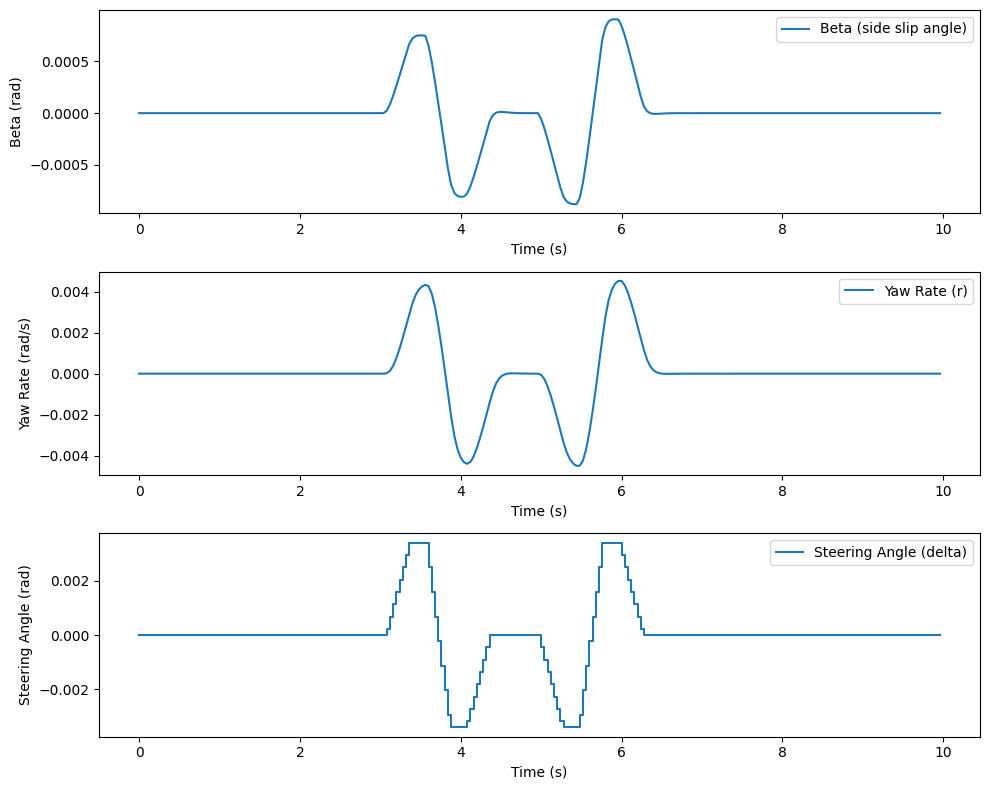

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(time[:-1], beta, label='Beta (side slip angle)')
plt.xlabel('Time (s)')
plt.ylabel('Beta (rad)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time[:-1], r, label='Yaw Rate (r)')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (rad/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.step(time[:-1], delta, where='post', label='Steering Angle (delta)')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (rad)')
plt.legend()

plt.tight_layout()
plt.show()


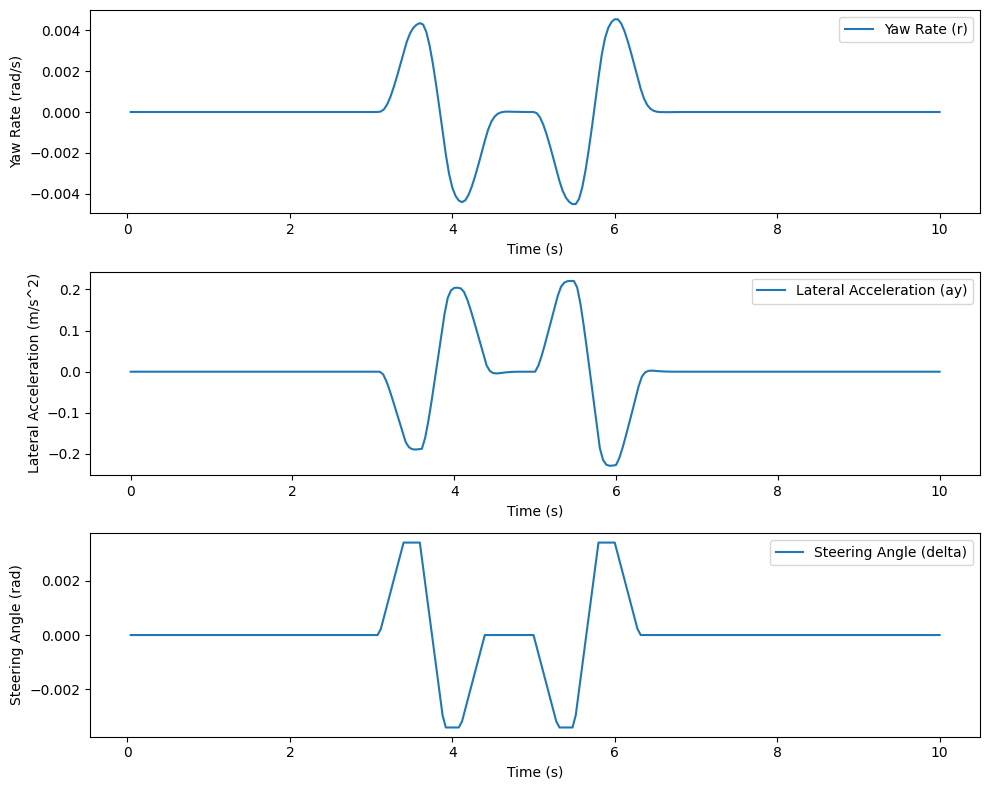

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(time[1:], r, label='Yaw Rate (r)')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (rad/s)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, ay, label='Lateral Acceleration (ay)')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Acceleration (m/s^2)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[1:], delta, label='Steering Angle (delta)')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (rad)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
state_init

array([[-6.173441e-23],
       [-6.173441e-23]])

**MPC implementation**

---



In [ ]:
!pip install casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 8.0 MB/s eta 0:00:00


In [ ]:
!apt-get install -y coinor-libipopt-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  coinor-libipopt1v5 libmumps-5.4 libmumps-dev libmumps-headers-dev libmumps-seq-5.4
  libmumps-seq-dev libscalapack-mpi-dev libscalapack-openmpi-dev libscalapack-openmpi2.1
  libscotch-6.1
Suggested packages:
  scalapack-doc
The following NEW packages will be installed:
  coinor-libipopt-dev coinor-libipopt1v5 libmumps-5.4 libmumps-dev libmumps-headers-dev
  libmumps-seq-5.4 libmumps-seq-dev libscalapack-mpi-dev libscalapack-openmpi-dev
  libscalapack-openmpi2.1 libscotch-6.1
0 upgraded, 11 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 64.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libscalapack-openmpi2.1 amd64 2.1.0-4 [1,534 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmumps-5.4 amd64 5.4.1-2 [1,82

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import signal
from casadi import *
class DataPreparation:
    def __init__(self, drivingProfile) -> None:
        self.m = drivingProfile['m'][0]
        self.lf = drivingProfile['lf'][0]
        self.lr = drivingProfile['lr'][0]
        self.Cf = drivingProfile['Cf'][0]
        self.Cr = drivingProfile['Cr'][0]
        self.Iz = drivingProfile['Iz'][0]
        self.steering_ratio = drivingProfile['steering_ratio'][0]
        self.Ts = drivingProfile['Sampling Period'][0]

    def calculateParameters(self, v_x):
        A = np.array([
            [-(2*self.Cf+2*self.Cr)/(self.m*v_x), -1-(2*self.Cf*self.lf - 2*self.Cr*self.lr)/(self.m*v_x**2)],
            [(2*self.Cr*self.lr - 2*self.Cf*self.lf)/self.Iz, -(2*self.Cf*self.lf**2 + 2*self.Cr*self.lr**2)/(self.Iz*v_x)]
        ])
        B = np.array([
            [2*self.Cf/(self.m*v_x), 0],
            [2*self.Cf*self.lf/self.Iz, 1/self.Iz]
        ])
        C = np.array([
            [0, 1],
            [-(2*self.Cf + 2*self.Cr)/self.m, -(2*self.Cf*self.lf - 2*self.Cr*self.lr)/(self.m*v_x)]
        ])
        D = np.array([
            [0, 0],
            [2*self.Cf/self.m, 0]
        ])
        return [A, B, C, D]

    def resampleData(self, Time, deltaSteer, Vx,time_diff):
        # n = math.floor(self.Ts/(Time[1]-Time[0]))
        if len(Time) < 2:
            raise ValueError("Time array must contain at least two elements.")
        # time_diff = Time[1] - Time[0]
        if time_diff == 0:
            raise ValueError("Time array elements must be distinct.")
        n = math.floor(self.Ts / time_diff)
        if n == 0:
            raise ValueError("Sampling period Ts is too small compared to the time differences in the Time array.")
        time = [Time[i] for i in range(len(Time)) if i % n == 0]
        steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i % n == 0]
        velocity = [Vx[i] for i in range(len(Vx)) if i % n == 0]
        return time, steeringAngle, velocity

    def getOutput(self, Time, deltaSteer, Vx, time_diff,mpc):
        time, steering_angle, velocity = self.resampleData(Time, deltaSteer, Vx,time_diff)
        u = mpc.computeControlInput(np.array([[0], [0]]), steering_angle,velocity)

        r = []
        y = []

        for i in range(1, len(velocity)):
            A, B, C, D = self.calculateParameters(velocity[i-1])
            out = signal.StateSpace(A, B, C, D).to_discrete(self.Ts)
            x = np.dot(out.A, np.array([[0], [0]])) + np.dot(out.B, u[i-1])
            y.append(np.dot(out.C, x) + np.dot(out.D, u[i-1]))
            r.append(x[1, 0])

        ay = [yi[1, 0] for yi in y]
        return time, r, ay

    def getInput(self, Time, deltaSteer, Vx,time_diff, mpc):
        time, steering_angle, velocity = self.resampleData(Time, deltaSteer, Vx,time_diff)
        u = mpc.computeControlInput(np.array([[0], [0]]), steering_angle,velocity)

        delta = [ui[0] for ui in u]
        Mz = [ui[1] for ui in u]
        return time, velocity, delta, Mz

    def getStates(self, Time, deltaSteer, Vx,time_diff, mpc):
        time, steering_angle, velocity = self.resampleData(Time, deltaSteer, Vx,time_diff)
        u = mpc.computeControlInput(np.array([[0], [0]]), steering_angle,velocity)

        beta = []
        r = []

        for i in range(1, len(velocity)):
            A, B, C, D = self.calculateParameters(velocity[i-1])
            out = signal.StateSpace(A, B, C, D).to_discrete(self.Ts)
            x = np.dot(out.A, np.array([[0], [0]])) + np.dot(out.B, u[i-1])
            beta.append(x[0, 0])
            r.append(x[1, 0])

        return time, beta, r

In [ ]:
class MPCController:
    def __init__(self, dp: DataPreparation):
        self.dp = dp
        self.Ts = dp.Ts
        self.N = 10
        self.Q = np.eye(2)
        self.R = np.eye(2)

        self.opts = {'ipopt.print_level': 0, 'print_time': 0}

    def setupMPC(self, velocity):
        A, B, _, _ = self.dp.calculateParameters(np.mean(velocity))
        Ad = np.eye(2) + A * self.Ts
        Bd = B * self.Ts

        x_casadi = SX.sym('x0', 2)
        u_casadi = SX.sym('u0', 2)
        x_ref = SX.sym('x_ref', 2)
        u_ref = SX.sym('u_ref', 2)

        x = x_casadi
        cost = 0
        g = []

        for k in range(self.N):
            x = mtimes(Ad, x) + mtimes(Bd, u_casadi)
            cost += mtimes((x - x_ref).T, mtimes(self.Q, (x - x_ref))) + \
                    mtimes((u_casadi - u_ref).T, mtimes(self.R, (u_casadi - u_ref)))
            g.append(x)

        nlp_prob = {'f': cost, 'x': vertcat(x_casadi, u_casadi), 'g': vertcat(*g), 'p': vertcat(x_ref, u_ref)}
        self.solver = nlpsol('solver', 'ipopt', nlp_prob, self.opts)

    def computeControlInput(self, x0, steering_angle, velocity):
        u = []
        for i in range(1, len(steering_angle)):
            A, B, C, D = self.dp.calculateParameters(velocity[i-1])
            out = signal.StateSpace(A, B, C, D).to_discrete(self.dp.Ts)

            x0_val = x0.flatten()
            x_ref_val = DM([0, 0])
            u_ref_val = DM([steering_angle[i] * (math.pi / 180) * self.dp.steering_ratio, 0])

            # Ensure x0 is a CasADi DM type and the correct shape
            x0_input = DM(np.concatenate([x0_val, np.zeros(2)]))[:4]  # Correctly slice to ensure shape is (4,)

            sol = self.solver(x0=vertcat(DM(x0_input)), p=vertcat(x_ref_val, u_ref_val))
            u_opt = sol['x'][-2:]
            u.append(u_opt.full().flatten())
            # print("Shapes before multiplication:")
            # print("x0 shape:", x0_val.shape)
            # print("out.A shape:", out.A.shape)
            # print("u_opt shape:", u_opt.shape)
            # print("out.B shape:", out.B.shape)

            x0 = np.dot(out.A, x0) + np.dot(out.B, u_opt.full().flatten())

        return u


In [ ]:
import pandas as pd

# Load parameters and input data
parameters = pd.read_csv('./parameter.csv')
input_data = pd.read_csv('./SLC_input.csv')

# Create DataPreparation object
dp = DataPreparation(parameters)
mpc = MPCController(dp)

# Resample the input data
time_data, steering_angle, velocity = dp.resampleData(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'],input_data['time'][1] - input_data['time'][0])

# Setup MPC controller
mpc.setupMPC(velocity)

# Compute control input
x0 = np.array([[0], [0]])
control_inputs = mpc.computeControlInput(x0, steering_angle, velocity)

# Extract data for output, input, and states
time_data, r, ay = dp.getOutput(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'],input_data['time'][1] - input_data['time'][0],mpc)
time_data, velocity, delta, Mz = dp.getInput(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'],input_data['time'][1] - input_data['time'][0],mpc)
time_data, beta, r = dp.getStates(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'],input_data['time'][1] - input_data['time'][0],mpc)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



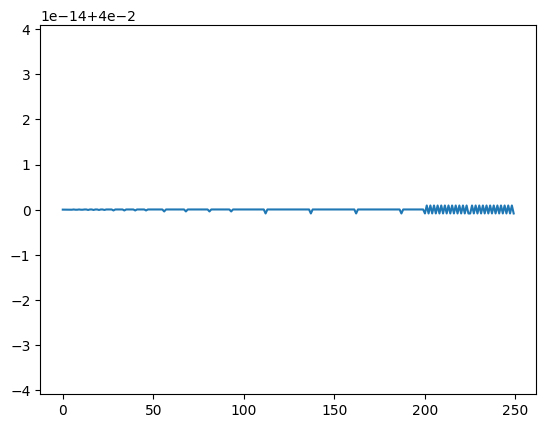

In [ ]:
plt.plot(np.subtract(time_data[1:],time_data[:-1]))
# plt.ylim((-0.05,0.05))

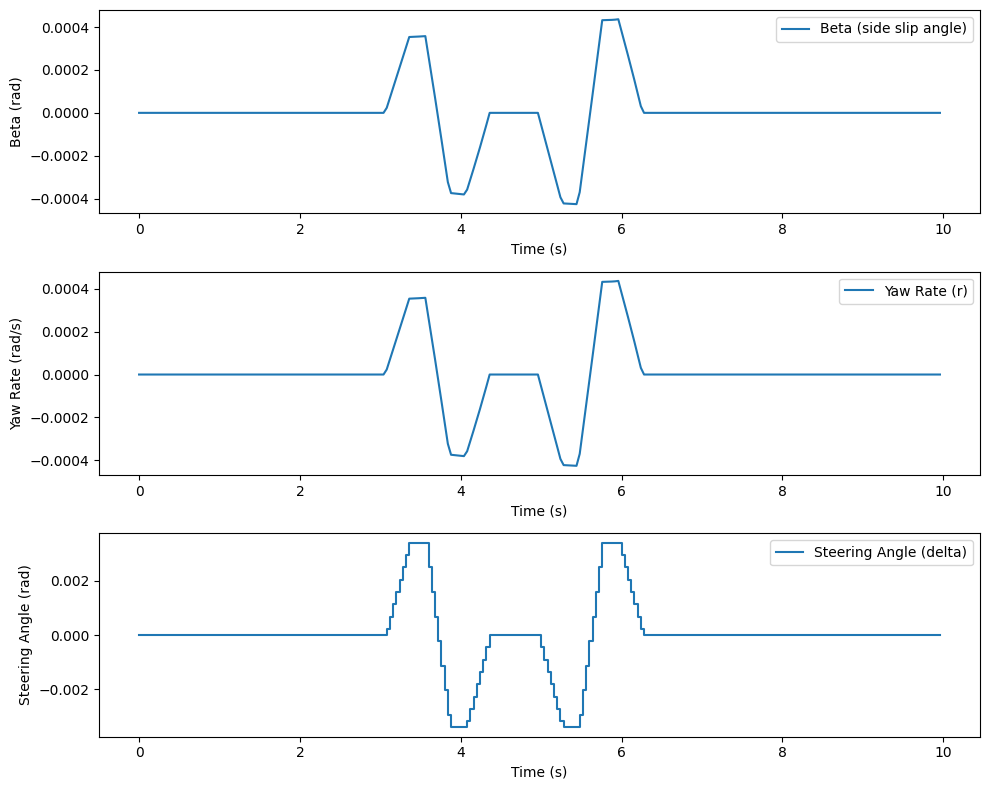

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(time_data[:-1], beta, label='Beta (side slip angle)')
plt.xlabel('Time (s)')
plt.ylabel('Beta (rad)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_data[:-1], r, label='Yaw Rate (r)')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (rad/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.step(time_data[:-1], delta, where='post', label='Steering Angle (delta)')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (rad)')
plt.legend()

plt.tight_layout()
plt.show()


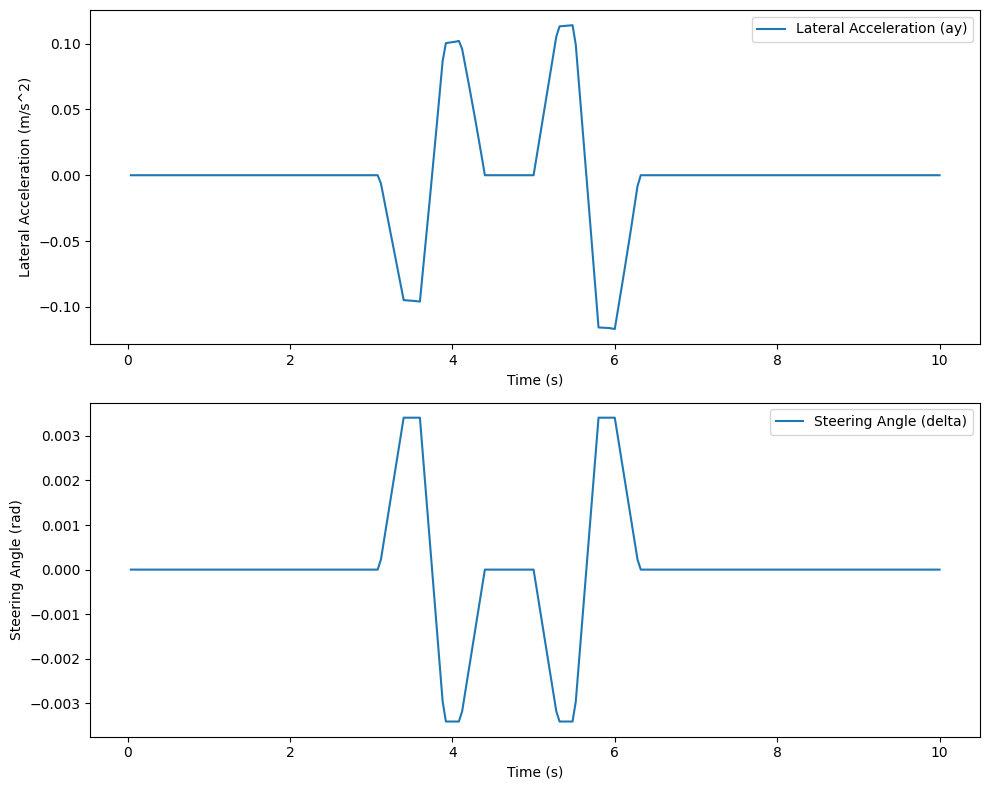

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(time_data[1:], ay, label='Lateral Acceleration (ay)')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Acceleration (m/s^2)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_data[1:], delta, label='Steering Angle (delta)')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (rad)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import casadi as ca
from time import time

# Load parameters and input data
parameters = pd.read_csv('./parameter.csv')
input_data = pd.read_csv('./SLC_input.csv')

# Create DataPreparation object
dp = DataPreparation(parameters)
mpc = MPCController(dp)

# Resample the input data
time_data, steering_angle, velocity = dp.resampleData(input_data['time'], input_data['Drv_DeltaSteer'], input_data['Veh_Vx'],input_data['time'][1] - input_data['time'][0])

# Setup MPC controller
mpc.setupMPC(velocity)

# Compute control input
x0 = np.array([[1], [1]])

# Run the MPC loop
main_loop = time()  # Start the main loop timer
state_init = np.array([[1], [1]])  # Initial state
state_target = np.array([[2], [2]])  # Target state (for example, modify as needed)

# Lists to store results
all_time_data = []
all_r = []
all_ay = []
all_velocity = []
all_delta = []
all_Mz = []
all_beta = []
all_r_states = []
sim_time = 1

# Iterate over the simulation time
i=0
while np.linalg.norm(np.subtract(state_target,state_init)) > 1e-4 and i*mpc.N < sim_time:
    # Update the MPC with current state
    t1 = time()
    control_input = mpc.computeControlInput(state_init, steering_angle[i:], velocity[i:])

    # Compute the outputs
    t, r, ay = dp.getOutput(time_data[i:], steering_angle[i:], velocity[i:], input_data['time'][1] - input_data['time'][0],mpc)
    _, velocity_out, delta, Mz = dp.getInput(time_data[i:], steering_angle[i:], velocity[i:],input_data['time'][1] - input_data['time'][0], mpc)
    _, beta, r_states = dp.getStates(time_data[i:], steering_angle[i:], velocity[i:], input_data['time'][1] - input_data['time'][0],mpc)

    # Store results
    all_time_data.extend(t)
    all_r.extend(r)
    all_ay.extend(ay)
    all_velocity.extend(velocity_out)
    all_delta.extend(delta)
    all_Mz.extend(Mz)
    all_beta.extend(beta)
    all_r_states.extend(r_states)

    # Update state_init for the next iteration (this is a simple example, more complex logic may be needed)
    state_init = np.array([[beta[-1]], [r_states[-1]]])
    sim_time = time()-t1
    i += 1
# Print out some results
print('Simulation complete.')
print('Total time:', time() - main_loop)
print('Time taken per iteration:',sim_time)
print('Iterations:',i)
# simulate(cat_states, cat_controls, time_data, dp.Ts, len(time_data)-1, reference)

Simulation complete.
Total time: 1.436126708984375
Time taken per iteration: 1.433873176574707
Iterations: 1


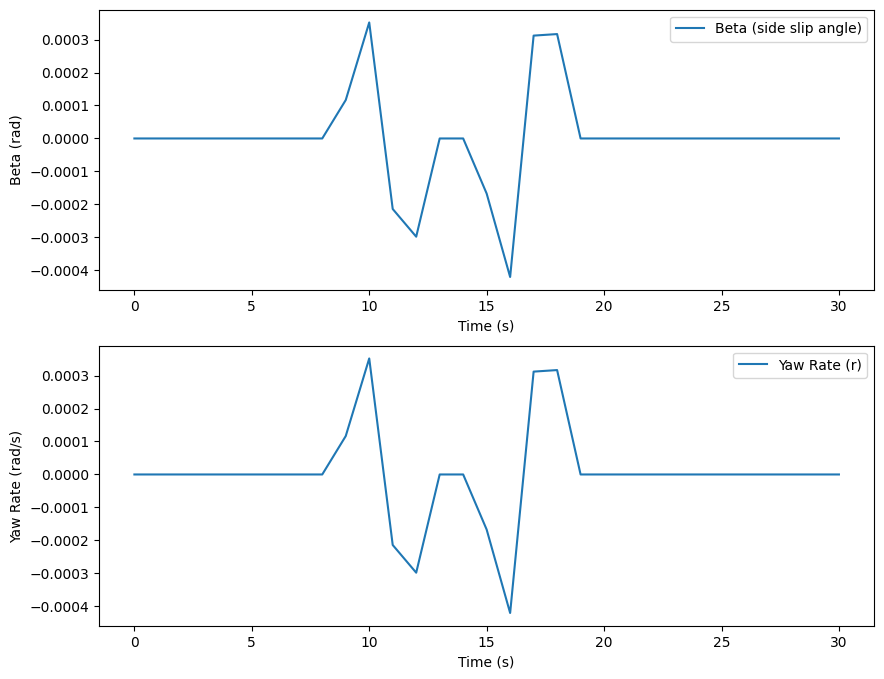

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(all_beta, label='Beta (side slip angle)')
plt.xlabel('Time (s)')
plt.ylabel('Beta (rad)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_r, label='Yaw Rate (r)')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (rad/s)')
plt.legend()

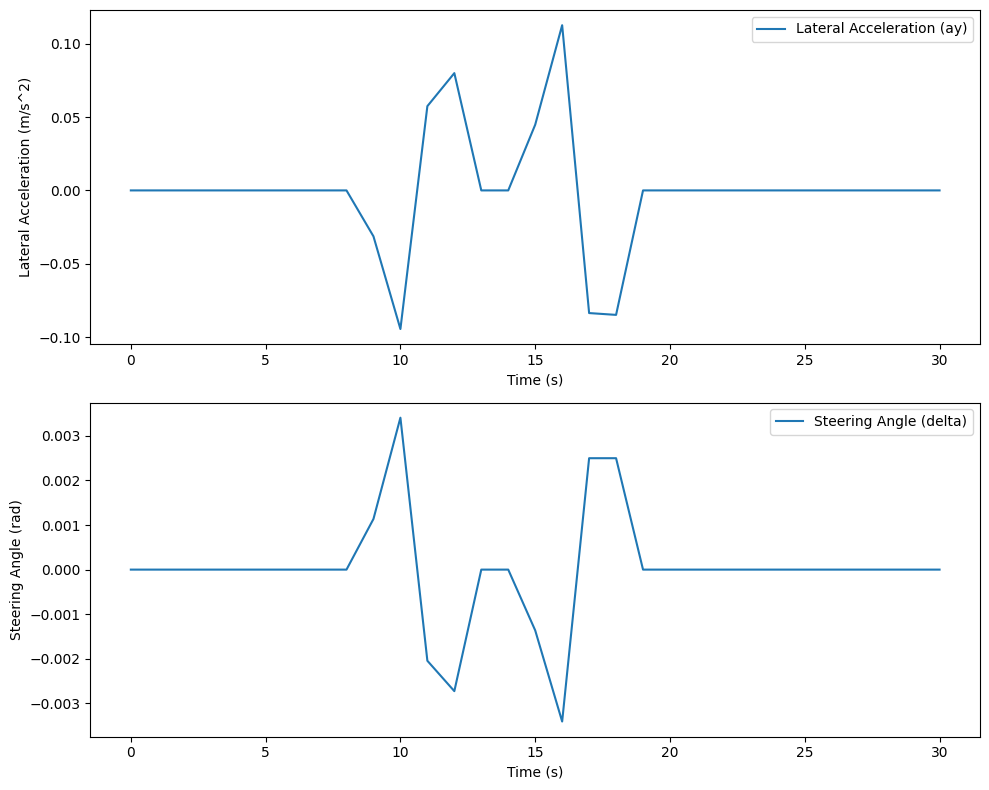

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(all_ay, label='Lateral Acceleration (ay)')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Acceleration (m/s^2)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_delta, label='Steering Angle (delta)')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (rad)')
plt.legend()

plt.tight_layout()
plt.show()